In [1]:
import pandas as pd

In [2]:
test_path = 'dataset/fraudTest.csv'
train_path = 'dataset/fraudTrain.csv'
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [110]:
X = df_train.drop(columns=["Unnamed: 0","first","last","street","city","state","zip","is_fraud","cc_num","unix_time","trans_num"])
y = df_train["is_fraud"]
X_test = df_test.drop(columns=["Unnamed: 0","first","last","street","city","state","zip","is_fraud","cc_num","unix_time","trans_num"])
y_test = df_test["is_fraud"]

X["age"] = (pd.to_datetime(X["trans_date_trans_time"]) - pd.to_datetime(X["dob"])).dt.days // 365
X_test["age"] = (pd.to_datetime(X_test["trans_date_trans_time"]) - pd.to_datetime(X_test["dob"])).dt.days // 365

X.drop(columns=["trans_date_trans_time","dob"],inplace=True)
X_test.drop(columns=["trans_date_trans_time","dob"],inplace=True)

Use Target Encoding for now

In [111]:
encodings = ["merchant", "category", "job"]
X_y = pd.concat([X,y], axis = 1)
for feature in encodings:
    means = X_y.groupby(feature)["is_fraud"].mean()
    X_y[feature] = X_y[feature].map(means)

X_be = X_y.drop(columns="is_fraud")
y = X_y["is_fraud"]

encodings = ["merchant", "category", "job"]
X_y = pd.concat([X_test,y_test], axis = 1)
for feature in encodings:
    means = X_y.groupby(feature)["is_fraud"].mean()
    X_y[feature] = X_y[feature].map(means)

X_be_test = X_y.drop(columns="is_fraud")
y_test = X_y["is_fraud"]
    
X_be["gender"] = (X_be["gender"] == "M") * 1


Scale features appropriately

In [112]:
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler()

def robust_scaling(df, feature):
    scaled = rob_scaler.fit_transform(df[feature].values.reshape(-1,1))
    return scaled

features_to_scale = ["amt","city_pop"]
for feature in features_to_scale:
    X_be[feature] = robust_scaling(X_be, feature)

def scale_longlat(df, feature):
    scaled = df[feature]/100
    return scaled

long_lat_ls = ["lat","long","merch_lat","merch_long"]
for feature in long_lat_ls:
    X_be[feature] = scale_longlat(X_be, feature)

from sklearn.preprocessing import MinMaxScaler
min_max = MinMaxScaler()
X_be["age"] = min_max.fit_transform(X_be[["age"]])

Want to keep original dataset before under-sampling

In [113]:
df = pd.concat([X_be, y], axis = 1)
df = df.sample(frac = 1)

In [114]:
from sklearn.model_selection import StratifiedKFold

X = df.drop("is_fraud", axis = 1)
y = df["is_fraud"]

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

Train: [ 259320  259321  259322 ... 1296672 1296673 1296674] Test: [     0      1      2 ... 261589 262212 262241]
Train: [      0       1       2 ... 1296672 1296673 1296674] Test: [259320 259321 259322 ... 528574 529501 529830]
Train: [      0       1       2 ... 1296672 1296673 1296674] Test: [518623 518624 518625 ... 784598 784770 784850]
Train: [      0       1       2 ... 1296672 1296673 1296674] Test: [ 777957  777958  777959 ... 1037365 1037366 1037367]
Train: [      0       1       2 ... 1037365 1037366 1037367] Test: [1033098 1033109 1033204 ... 1296672 1296673 1296674]


Performing Random Under-Sampling

In [115]:
#extract fraudulent claims and undersample
fraud_df = df.loc[df['is_fraud'] == 1]
non_fraud_df = df.loc[df['is_fraud'] == 0][:fraud_df.shape[0]]

#combine df and shuffle
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
new_df = normal_distributed_df.sample(frac=1, random_state=42)

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
""" print('Distribution of the Classes in the subsample dataset')
print(new_df['is_fraud'].value_counts()/len(new_df))

sns.countplot(x='is_fraud', data= new_df)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show() """

In [ ]:
f, ax1 = plt.subplots(1, 1, figsize=(10,5))
subsampled_cor = new_df.corr()
sns.heatmap(subsampled_cor, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

Merchant and Category are highly correlated with each other
latitude is negatively correlated with city_pop and positively correlated with merch_lat
long pos correlated with merch long


Removing extreme outliers via IQR method --- for now ignore

Dimensionality reduction via TSNE ---- for now ignore

NN implementation previous to undersampling ---- prone to overfit

In [116]:
from sklearn.model_selection import train_test_split

X = new_df.drop("is_fraud", axis = 1)
y = new_df["is_fraud"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [80]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix, classification_report
import random

In [117]:
seed_value = 117
random.seed(seed_value)

model = Sequential()

model.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))

model.add(Dense(units = 32, activation = "relu"))

model.add(Dense(units = 2, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [118]:
model.fit(X_train, y_train, validation_split = 0.2, batch_size=25, epochs = 30, shuffle=True, verbose = 2)

Epoch 1/30
385/385 - 1s - 3ms/step - accuracy: 0.8503 - loss: 0.3989 - val_accuracy: 0.8443 - val_loss: 0.3711
Epoch 2/30
385/385 - 0s - 1ms/step - accuracy: 0.8603 - loss: 0.3418 - val_accuracy: 0.8555 - val_loss: 0.3360
Epoch 3/30
385/385 - 0s - 1ms/step - accuracy: 0.8620 - loss: 0.3334 - val_accuracy: 0.8514 - val_loss: 0.3547
Epoch 4/30
385/385 - 0s - 1ms/step - accuracy: 0.8589 - loss: 0.3300 - val_accuracy: 0.8468 - val_loss: 0.3476
Epoch 5/30
385/385 - 0s - 1ms/step - accuracy: 0.8645 - loss: 0.3143 - val_accuracy: 0.8580 - val_loss: 0.3197
Epoch 6/30
385/385 - 0s - 1ms/step - accuracy: 0.8694 - loss: 0.3053 - val_accuracy: 0.8639 - val_loss: 0.3130
Epoch 7/30
385/385 - 0s - 1ms/step - accuracy: 0.8731 - loss: 0.3000 - val_accuracy: 0.8576 - val_loss: 0.3269
Epoch 8/30
385/385 - 0s - 1ms/step - accuracy: 0.8718 - loss: 0.2977 - val_accuracy: 0.8697 - val_loss: 0.3119
Epoch 9/30
385/385 - 0s - 1ms/step - accuracy: 0.8805 - loss: 0.2863 - val_accuracy: 0.8618 - val_loss: 0.3154
E

In [119]:
import numpy as np
pred_undersample = (model.predict(original_Xtest, batch_size = 200, verbose = 1) > 0.5).astype(int)
pred_undersample = np.argmax(pred_undersample, axis = 1)

1297/1297 ━━━━━━━━━━━━━━━━━━━━ 1s 570us/step


In [ ]:
import itertools
# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

output is what we expect, the model has been overfit on the dataset

Confusion matrix, without normalization
[[225109  32724]
 [   132   1370]]


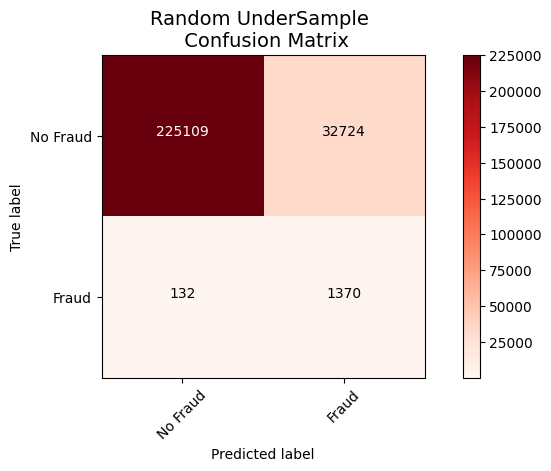

In [122]:
undersample_preds = confusion_matrix(original_ytest, pred_undersample)
labels = ['No Fraud', 'Fraud']
fig = plt.figure(figsize=(16,8))
fig.add_subplot(221)
plot_confusion_matrix(undersample_preds, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

Now we try NN after SMOTE

In [125]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy = "minority", random_state=42)
Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)

In [127]:
len(Xsm_train)

2062672

In [143]:
seed_value = 117
random.seed(seed_value)

oversample_model = Sequential()

oversample_model.add(Dense(units=64, activation='relu', input_shape=(Xsm_train.shape[1],)))

oversample_model.add(Dense(units = 64, activation = "relu"))

oversample_model.add(Dense(units = 2, activation='softmax'))

oversample_model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [144]:
oversample_model.fit(Xsm_train, ysm_train, validation_split = 0.2, batch_size = 100, epochs = 30, shuffle = True, verbose = 2)

Epoch 1/30
16502/16502 - 16s - 982us/step - accuracy: 0.9227 - loss: 0.1891 - val_accuracy: 0.9308 - val_loss: 0.1774
Epoch 2/30
16502/16502 - 15s - 937us/step - accuracy: 0.9419 - loss: 0.1459 - val_accuracy: 0.8921 - val_loss: 0.2630
Epoch 3/30
16502/16502 - 16s - 952us/step - accuracy: 0.9457 - loss: 0.1366 - val_accuracy: 0.9541 - val_loss: 0.1305
Epoch 4/30
16502/16502 - 15s - 938us/step - accuracy: 0.9486 - loss: 0.1298 - val_accuracy: 0.9166 - val_loss: 0.2068
Epoch 5/30
16502/16502 - 15s - 936us/step - accuracy: 0.9502 - loss: 0.1264 - val_accuracy: 0.9405 - val_loss: 0.1578
Epoch 6/30
16502/16502 - 16s - 943us/step - accuracy: 0.9522 - loss: 0.1220 - val_accuracy: 0.9350 - val_loss: 0.1755
Epoch 7/30
16502/16502 - 16s - 973us/step - accuracy: 0.9531 - loss: 0.1195 - val_accuracy: 0.9125 - val_loss: 0.2229
Epoch 8/30
16502/16502 - 16s - 945us/step - accuracy: 0.9541 - loss: 0.1173 - val_accuracy: 0.9438 - val_loss: 0.1509
Epoch 9/30
16502/16502 - 17s - 1ms/step - accuracy: 0.95

In [145]:
preds = (oversample_model.predict(original_Xtest, batch_size=200, verbose = 1) > 0.5).astype(int)
preds = np.argmax(preds, axis = 1)

1297/1297 ━━━━━━━━━━━━━━━━━━━━ 1s 615us/step


Model now performs much better we can see we do not significantly misclassify no fraud as fraud anymore and this only occurs for a minute set of cases

Confusion matrix, without normalization
[[249112   8721]
 [   146   1356]]


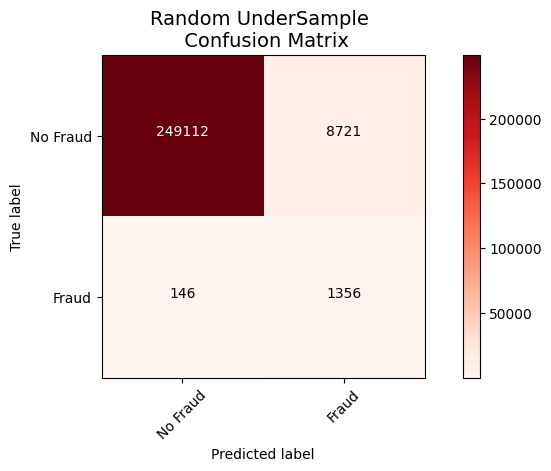

In [146]:
oversample_preds = confusion_matrix(original_ytest, preds)
labels = ['No Fraud', 'Fraud']
fig = plt.figure(figsize=(16,8))
fig.add_subplot(221)
plot_confusion_matrix(oversample_preds, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

In [147]:
y_pred = oversample_model.predict(original_Xtest, batch_size=200, verbose = 1)
y_pred = np.argmax(y_pred, axis = 1)

1297/1297 ━━━━━━━━━━━━━━━━━━━━ 1s 564us/step


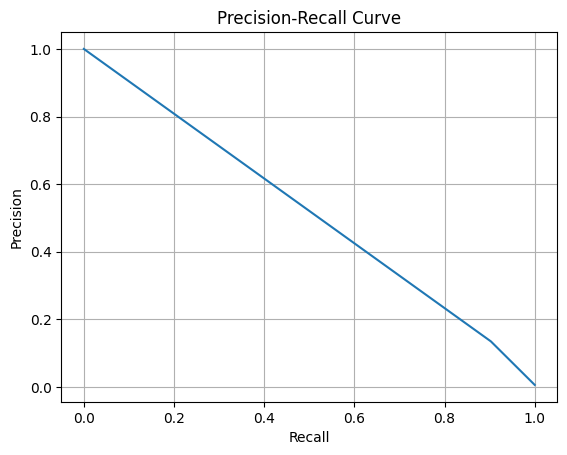

In [148]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(original_ytest, y_pred)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()